In [ ]:
%matplotlib widget
%matplotlib widget
import os
from pathlib import Path
import time
import torch
import numpy as np
import math
import gc
from functools import partial
from dataset import Dataset, load_dataframes_from_folder, reverse_normalization
from torch.utils.data import DataLoader
from transformer_zerostep import GPTConfig, GPT, warmup_cosine_lr
import argparse
import warnings
import matplotlib.pyplot as plt
import glob
import pandas as pd
import os

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams['axes.labelsize']=14
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['axes.grid']=True
plt.rcParams['axes.xmargin']=0
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['legend.fontsize']=11

fig_width = 6
fig_width_big = 12

In [ ]:
current_path = os.getcwd().split("in-context-bldc")[0]
data_path = os.path.join(current_path,"in-context-bldc", "data")

folder = "CL_experiments_double_sensor_high_speed_ekf_and_meta/final"
folder_path = os.path.join(data_path, folder)


In [8]:
list_of_folders = glob.glob(os.path.join(folder_path, '*'))[:6]
print(list_of_folders)
identifiers = [list_of_folders[i].split("_")[-2][-9:] for i in range(len(list_of_folders))]
print(identifiers)

#### inertias [e-4]: I5 = 0.7, I15 = 3.1, I9 = 5.8, I11 = 6.8, I7 = 8.8
order = [0, 5, 2, 3, 1]
list_of_folders = [list_of_folders[j] for j in order]
identifiers = [identifiers[j] for j in order]
print(list_of_folders)
print(identifiers)

['c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_high_speed_ekf_and_meta/final\\inertia05_ki-0.0061-kp-11.8427', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_high_speed_ekf_and_meta/final\\inertia07_ki-0.0061-kp-11.8427', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_high_speed_ekf_and_meta/final\\inertia09_ki-0.0061-kp-11.8427', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_high_speed_ekf_and_meta/final\\inertia11_ki-0.0061-kp-11.8427', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_high_speed_ekf_and_meta/final\\inertia13_ki-0.0061-kp-11.8427', 'c:\\Users\\39340\\Documents\\GitHub\\in-context-bldc\\data\\CL_experiments_double_sensor_high_speed_ekf_and_meta/final\\inertia15_ki-0.0061-kp-11.8427']
['inertia05', 'inertia07', 'inertia09', 'inertia11', 'inertia13', 'inertia1

In [9]:

profile_list_meta = []
profile_list_ekf = []
profile_list_real = []

for exp_idx in range(len(list_of_folders)):
    profile_config_meta = []
    profile_config_ekf = []
    profile_config_real = []
    exp_path = list_of_folders[exp_idx]
    csv_list = glob.glob(os.path.join(exp_path, "*.csv"))
    for file in csv_list:

        df = pd.read_csv(file)
        profile_config_real.append(df["omega"].to_numpy()[0:2000])
        profile_config_meta.append(df["omega_meta"].to_numpy()[0:2000])
        profile_config_ekf.append(df["omega_ekf"].to_numpy()[0:2000])

    profile_list_real.append(  np.row_stack(profile_config_real)    )
    profile_list_meta.append(  np.row_stack(profile_config_meta)    )
    profile_list_ekf.append(   np.row_stack(profile_config_ekf)     )
    # print(np.row_stack(profile_config_real).shape)

# print(rmse_list_meta)
time = df['t'].to_numpy()[0:2000]

profile_full_real = np.stack(profile_list_real)
profile_full_meta = np.stack(profile_list_meta)
profile_full_ekf = np.stack(profile_list_ekf)
config_number, exp_number, exp_length = profile_full_meta.shape
print(config_number)
print(exp_number)
print(exp_length)

5
10
2000


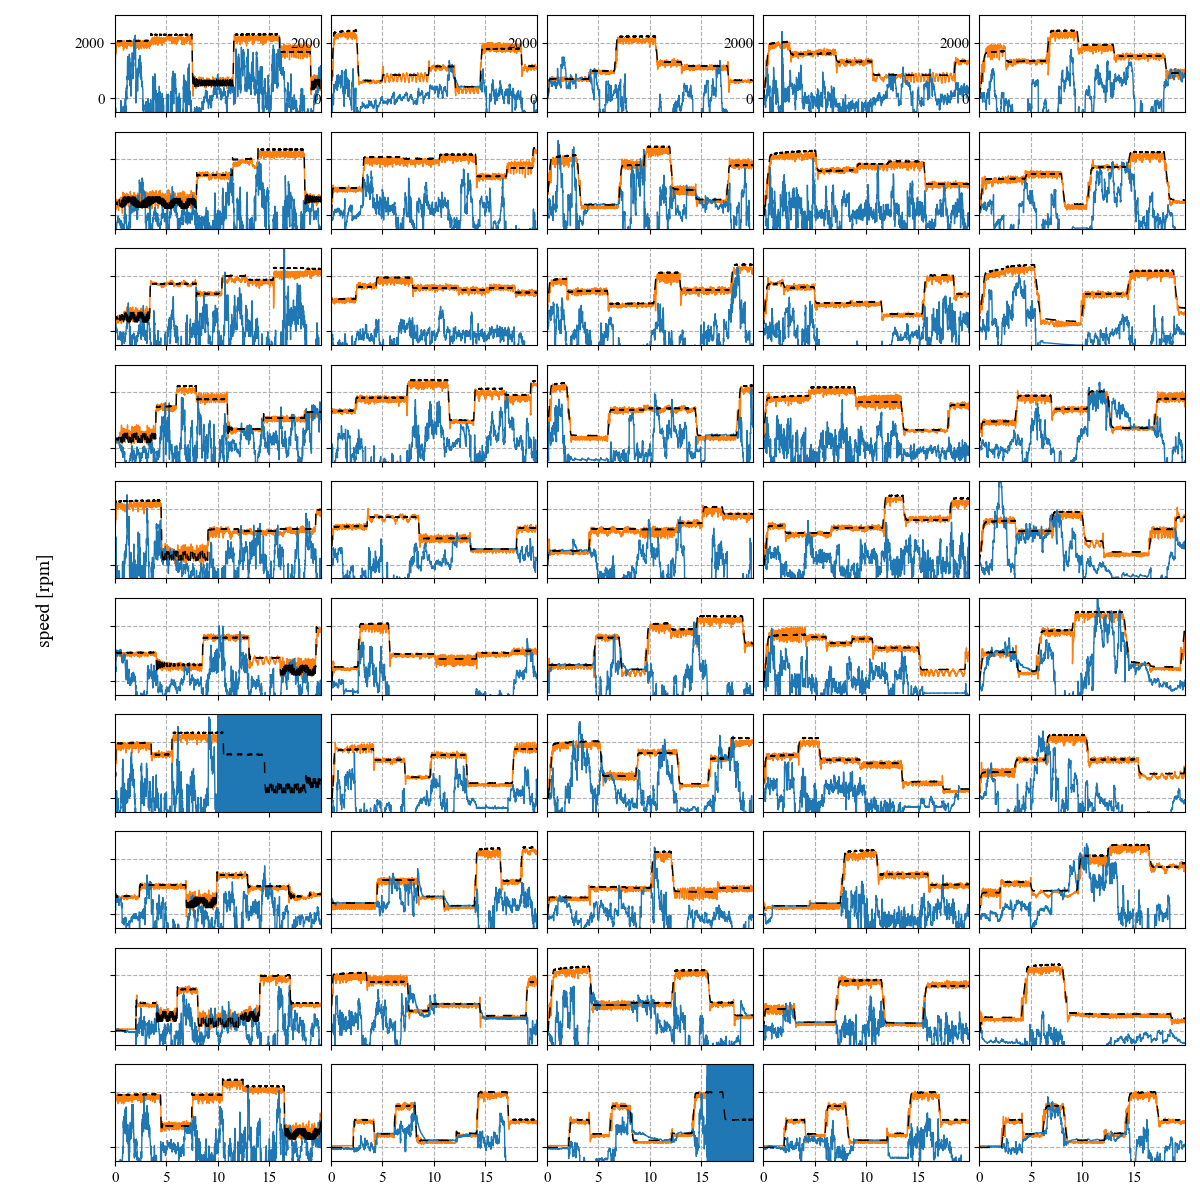

In [10]:
fig, axes = plt.subplots(10, config_number, figsize=(12, 12), sharex=True)

index_exp_list = [0,0,0,0,0,0]

for config_idx in range(config_number):
# for config_idx in range(1):

    for exp_i in range(exp_number):
        

        axes[exp_i,config_idx].plot(time,profile_full_meta[config_idx,exp_i,:], label=r"$\hat{\omega}_{\mathcal{F}}$", color="tab:orange", linewidth = 1)
        axes[exp_i,config_idx].plot(time,profile_full_ekf[config_idx,exp_i,:], label=r"$\hat{\omega}_{EKF}$", color="tab:blue", linewidth = 1)
        axes[exp_i,config_idx].plot(time,profile_full_real[config_idx,exp_i,:], label=r"$\omega$", color="k", linestyle=(0, (8, 8)), linewidth = 1)
        axes[exp_i,config_idx].set_ylim([-500, 3000])
        if exp_i != 0:
            axes[exp_i,config_idx].set_yticklabels([])
        # elif axis_col == 1:
        #     axes[axis_row,axis_col].set_ylabel("Speed [RPM]")


plt.tight_layout(rect=[0.05, 0, 1, 1])
# plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.2)
fig.text(0.03, 0.5, 'speed [rpm]', va='center', rotation='vertical', fontsize=14)


# plt.savefig("figures\\gridplot.pdf", dpi=300)
plt.show()


<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
C:\Users\39340\AppData\Local\Temp\ipykernel_28940\3428065209.py:25: SyntaxWarning: invalid escape sequence '\o'
  fig.text(0.03, 0.5, '$\omega$ [rpm]', va='center', rotation='vertical', fontsize=14)


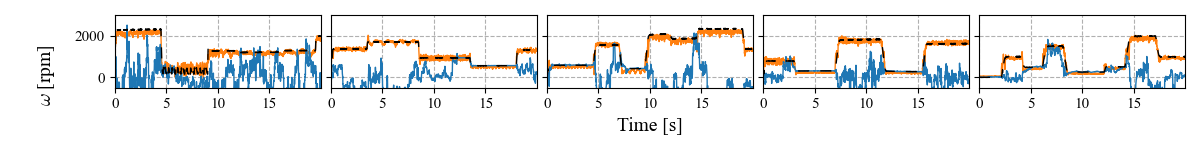

In [11]:
fig, axes = plt.subplots(1, 5, figsize=(12, 1.5), sharex=True)

index_exp_list = [4,4,5,8,9]

for config_idx in range(config_number):
# for config_idx in range(1):
    # axis_row = config_idx//3
    # axis_col = config_idx%3
    

    axes[config_idx].plot(time,profile_full_meta[config_idx,index_exp_list[config_idx],:], label=r"$\hat{\omega}_{\mathcal{F}}$", color="tab:orange", linewidth = 1)
    axes[config_idx].plot(time,profile_full_ekf[config_idx,index_exp_list[config_idx],:], label=r"$\hat{\omega}_{EKF}$", color="tab:blue", linewidth = 1)
    axes[config_idx].plot(time,profile_full_real[config_idx,index_exp_list[config_idx],:], label=r"$\omega$", color="k", linestyle=(0, (8, 8)), linewidth = 1)
    axes[config_idx].set_ylim([-500, 3000])
    if config_idx != 0:
        axes[config_idx].set_yticklabels([])
    # elif axis_col == 1:
    #     axes[axis_row,axis_col].set_ylabel("Speed [RPM]")


axes[2].set_xlabel("Time [s]")
plt.tight_layout(rect=[0.05, 0, 1, 1])
# plt.tight_layout()
plt.subplots_adjust(wspace=0.05, hspace=0.2)
fig.text(0.03, 0.5, '$\omega$ [rpm]', va='center', rotation='vertical', fontsize=14)


# plt.savefig("figures\\high_speed_plot_5.pdf", dpi=300)
plt.show()
